Le jeu de données Open Food Facts est disponible sur le site officiel (ou disponible à ce lien en téléchargement). Les variables sont définies à cette adresse.

Les champs sont séparés en quatre sections :

Les informations générales sur la fiche du produit : nom, date de modification, etc.
Un ensemble de tags : catégorie du produit, localisation, origine, etc.
Les ingrédients composant les produits et leurs additifs éventuels.
Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

# Partie 1 Idée d'application

Pour répondre à l'appel de l'Agence française santé publique, et en fonction des données à notre disposition,
nous proposons une application (web et ou mobile) qui propose des produits et ou catégories de produits au consommateur suivant les caractéristiques suivantes:
- le pays dans lequel où il réside et où les produits sont disponibles, 
- le sexe
- l'âge
- le poids 
- la taille
- les maladies dont souffre éventuellement le consommateur
- voir mêmes les éventuelles allergies

Bien entendu, la mise en place d'une application nécessité une collaboration avec des médecins, diététiciens, nutritionnistes afin de connaitre les nutriments et leurs valeurs respectives dont le consommateur a besoin selon sa situation tout minimisant l'impact sur l'environnement voir le nutriscore

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer 
from scipy import stats
#pd.set_option('display.max_rows', None) 

In [161]:
df=pd.read_csv('./food.csv',sep='\t',low_memory=False)

In [162]:
df.shape ## 320772 lignes et 172 colonnes

(320772, 162)

Afin de répondre à notre idée d'application ,la première chose qu'on fait reste le filtrage des données par pays.Etant donnée, qu'on vit en France, on s'intéresse aux produits disponibles en France

In [163]:
## filtrage des produits disponibles en France
df=df[(pd.notnull(df['countries'])) & (
(df['countries'].str.contains('FR')) |
    (df['countries'].str.contains('France'))
    | (df['countries'].str.contains('france'))
    | (df['countries'].str.contains('French'))
     | (df['countries'].str.contains('french'))
)]

In [164]:
df.isnull().sum()/len(df)*100

code                         0.000000
url                          0.000000
creator                      0.000000
created_t                    0.000000
created_datetime             0.001019
                              ...    
carbon-footprint_100g       99.820653
nutrition-score-fr_100g     37.641388
nutrition-score-uk_100g     37.641388
glycemic-index_100g        100.000000
water-hardness_100g        100.000000
Length: 162, dtype: float64

#  Traitements des colonnes

In [165]:
## fonction renvoyant les colonnes et le pourcentage de valeurs nulles pour chacune d'elle
def columns_na_percentage(df):
    na_df=(df.isnull().sum()/len(df)*100).sort_values(ascending=False).reset_index()
    na_df.columns = ['Column','na_rate_percent']
    return na_df
  

In [166]:
## variables comportant plus de 50% de valeurs manquantes
na_df=columns_na_percentage(df)
na_columns=na_df[na_df['na_rate_percent']>=50] ## 120 colonnes ont plus de 50% de valeurs nulles
#na_columns[na_columns['Column']=='manufacturing_places']
na_columns

,Column,na_rate_percent
0,water-hardness_100g,100.000000
1,nervonic-acid_100g,100.000000
2,mead-acid_100g,100.000000
3,gondoic-acid_100g,100.000000
4,elaidic-acid_100g,100.000000
...,...,...
115,generic_name,61.194897
116,purchase_places,56.025435
117,fiber_100g,53.524772
118,carbohydrates_100g,52.130760


In [167]:
## suppression des colonnes ayant plus 50% de valeurs nulles
df.drop(columns=na_columns['Column'].tolist(),axis=1,inplace=True)

In [168]:
## les colonnes code, url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime
  # sont peu utiles, et plus relatives au stockage en base de données
  # par conséquent, nous les supprimons
unuseless_columns =['code', 'url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime']
df.drop(columns=unuseless_columns,axis=1,inplace=True)

In [169]:
## ['categories','categories_tags','categories_fr','main_category'] restent les mêmes, on ne garde que categories
## ['brands','brands_tags'] restent les mêmes, on ne garde que brands
## ['additives_n','additives'] restent les mêmes, on ne garde que additives_n

## Au final, on ne retient que les variables suivantes
relevant_cols=[
    'product_name',
    
    'categories',
    'additives_n',
    'ingredients_from_palm_oil_n',
    'nutrition_grade_fr',
    
    
    ## toutes les valeurs nutritionnelles
    'energy_100g', 
    'saturated-fat_100g',
    'sugars_100g',
    'proteins_100g',
    'salt_100g', 
    'sodium_100g',
    'nutrition-score-fr_100g',
       
    
]
df=df[relevant_cols]

## Traitement des lignes

In [170]:
## le nom du produit censé être unique et non nul
## suppression de toutes les lignes dont le nom du produit est non renseigné ou nul
missing_product_name=df[(pd.isna(df['product_name']))|(df['product_name'].str.strip()=='')]
missing_product_name[['product_name']] ##7172 lignes à supprimmer
#df=df[~pd.isna(df['product_name'])]

,product_name
48,NaN
183,NaN
187,NaN
227,NaN
280,NaN
...,...
320718,NaN
320745,NaN
320746,NaN
320747,NaN


In [171]:
## suppression des produits dont les noms ne sont pas renseignés
df.drop(missing_product_name.index,inplace=True)

In [172]:
## vérification de doublons pour le nom du produit 23497 doublons
df[df['product_name'].duplicated(keep=False)][['product_name']]

,product_name
0,Farine de blé noir
240,7Up
242,Madeleines nature
271,Terrine de campagne
284,Chair à saucisse
...,...
320711,Lardons
320715,Graine couscous fin
320743,Gingembre
320757,Amandes


In [173]:
## suppression des doublons sur les produits
df.drop_duplicates(subset='product_name',keep='last',inplace=True)

In [174]:
## identification des colonnes décrivant la part nutritionnelle pour 100g
nutriment_cols=[i for i in df.columns.tolist() if i.endswith('_100g')]
nutriment_cols

['energy_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

In [175]:
## vérification des lignes comportant des valeurs nutritionnelles négatives
negative_cols=[]
for col in nutriment_cols:
    if len(df[df[col]<0])>0:
        negative_cols.append(col)

print('columns with negative values',negative_cols) 
## les variables ['sugars_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-fr_100g']
              ## comportent des valeurs négatives
## suppression des lignes comportant des valeurs nutritionnelles négatives
for col in negative_cols:
    df.drop(index=df.loc[df[col]<0,col].index,inplace=True)



columns with negative values ['sugars_100g', 'nutrition-score-fr_100g']


In [176]:
## identification des lignes dont toutes les valeurs nutritionnelles sont inconnues
all_missing_nutritional = df[df["energy_100g"].isna()
                            & df["proteins_100g"].isna()
                            & df["sugars_100g"].isna()
                          
            &df['sugars_100g'].isna()
                            
   
                             & df[ 'nutrition-score-fr_100g'].isna()
                           
                            & df["saturated-fat_100g"].isna()
                             
                            & df["sodium_100g"].isna() 
                    ] 
len(all_missing_nutritional[nutriment_cols] )## 21582

21582

In [177]:
## suppression des lignes dont toutes les valeurs nutritives sont inconnues ainsi que les nutriscores
df.drop(all_missing_nutritional.index,inplace=True)



In [178]:
df.isnull().sum()/len(df)*100

product_name                    0.000000
categories                     28.778580
additives_n                    33.956071
ingredients_from_palm_oil_n    33.956071
nutrition_grade_fr              6.274589
energy_100g                     0.537308
saturated-fat_100g              4.552506
sugars_100g                     4.260246
proteins_100g                   1.027405
salt_100g                       4.192801
sodium_100g                     4.195050
nutrition-score-fr_100g         6.274589
dtype: float64

# Analyse et recherche des valeurs aberrantes avec IQR (Inter Quartile Range)

In [179]:
df.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,29377.000000,29377.000000,44242.000000,42456.000000,42586.000000,44024.000000,42616.000000,42615.000000,41690.000000
mean,2.348334,0.099976,1192.784382,6.388728,15.455371,7.748537,1.311959,0.516530,11.102279
std,2.757704,0.304591,1173.160069,8.970960,20.003384,7.929492,4.680861,1.842803,7.790992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,503.000000,0.600000,1.200000,1.900000,0.100000,0.039370,4.000000
50%,1.000000,0.000000,1106.000000,2.900000,5.500000,6.000000,0.680000,0.267716,11.000000
75%,4.000000,0.000000,1770.000000,9.300000,24.700000,10.200000,1.400000,0.551181,17.000000
max,21.000000,2.000000,182764.000000,210.000000,105.000000,100.000000,211.000000,83.000000,40.000000


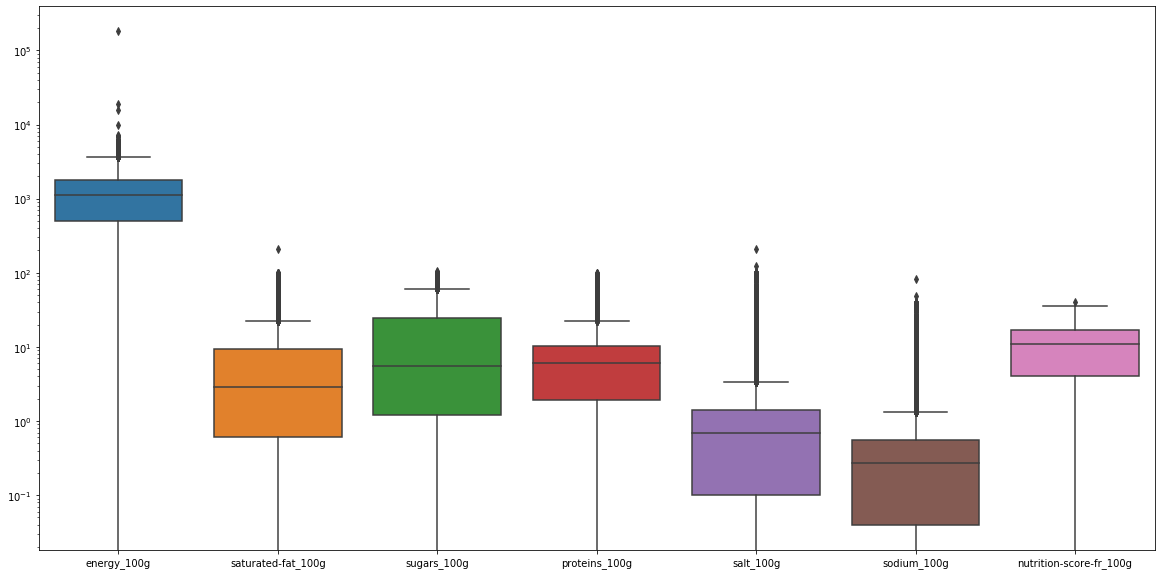

In [180]:
## afin de détecter d'éventuelles valeurs aberrantes, 
## nous traçons les boxplot pour  chaque valeurs nutritives ainsi que les nutriscore

## boxplot
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10
g=sns.boxplot(data=df[nutriment_cols])
g.set_yscale("log")

## présence de plusieurs valeurs aberrantes sauf pour le nutriscore


In [181]:
## suppression de toutes les valeurs nutririonnelles supérieures à 100g
##df[df[nutriment_cols]>100]
nutriment_cols=[i for i in df.columns.tolist() if i.endswith('_100g')]
for col in nutriment_cols:
    if col !='energy_100g':
        if len(df[df[col]>100]):
            #print(df[df[col]>100][col])
            df.drop(index=df[df[col]>100].index,inplace=True)

In [182]:
df.info() ##44475 lignes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44475 entries, 106 to 320763
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_name                 44475 non-null  object 
 1   categories                   31674 non-null  object 
 2   additives_n                  29372 non-null  float64
 3   ingredients_from_palm_oil_n  29372 non-null  float64
 4   nutrition_grade_fr           41685 non-null  object 
 5   energy_100g                  44236 non-null  float64
 6   saturated-fat_100g           42451 non-null  float64
 7   sugars_100g                  42580 non-null  float64
 8   proteins_100g                44019 non-null  float64
 9   salt_100g                    42611 non-null  float64
 10  sodium_100g                  42610 non-null  float64
 11  nutrition-score-fr_100g      41685 non-null  float64
dtypes: float64(9), object(3)
memory usage: 4.4+ MB


In [183]:
## fonction qui calcule les valeurs aberrantes sur un échantillon homogène de même catégorie
 # et   renvoit les noms des produits sous forme de list

 
 

def find_outliers_and_clean(col,category,df):

    df_by_category=df[df['categories']==category]
    Q1 = df_by_category[col].quantile(0.25)
    Q3 = df_by_category[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers= df_by_category[((df_by_category[col] < (Q1 - 1.5 * IQR)) |(df_by_category[col] > (Q3 + 1.5 * IQR))).any(axis=1)]
   
    #df=outliers.drop(index=outliers.index,inplace=True)
    if len(outliers)>0:
        #print('outliers for column '+str(col[0])+' and category '+str(category),outliers[['product_name',col[0]]])
        return outliers['product_name'].values.tolist()
    else:
        #print('no outliers for column '+str(col[0])+' and category '+str(category))
        return []
    

In [184]:
## exemple pour la catégorie Soda au cola sur la variable energy_100g
product_name=find_outliers_and_clean(['energy_100g'],'Sodas au cola',df)
product_name
 ## les produits Cola Edulcorant Naturel,Cola Classic Carrefour,Coca-Cola life 
    # sont considérés comme valeurs aberrantes selon la méthode interquartile
    


['Cola Edulcorant Naturel ', 'Cola Classic Carrefour', 'Coca-Cola life ']

In [185]:
## liste des produits par catégorie présentant des valeurs aberrantes selon
## cette fonction prend trop de temps à s'executer
outliers_products=[]
for category in df['categories'].unique():
    for col in nutriment_cols:
        outliers_products=outliers_products+find_outliers_and_clean([str(col)],category,df)
        
        
print(outliers_products)

['Cola Edulcorant Naturel ', 'Cola Classic Carrefour', 'Coca-Cola life ', 'Pure Sensation Cola Cherry', 'Planet Cola Cherry', 'Cola Edulcorant Naturel ', 'Fizz Cola Bio', 'Cola Classic Carrefour', 'Coca-Cola life ', 'Montania Cola', 'Soda aux extraits végétaux Cola', 'Pure Sensation Cola Cherry', 'Planet Cola Cherry', 'Limonade au cola pur sucre', 'Pepsi, Nouveau goût !', 'Soda aux extraits végétaux Cola', 'Quebec Soda', 'Cola Classic Carrefour', 'Pepsi, Nouveau goût !', 'Soda aux extraits végétaux Cola', 'Quebec Soda', 'Cola Classic Carrefour', 'Cola Edulcorant Naturel ', 'Cola Classic Carrefour', 'Coca-Cola life ', 'Stem Ginger Cookies', 'Cookies aux pépites de chocolat ', 'Organiser cookies', 'Cookies Noix de précan & pépites de chocolat', 'Organiser cookies', 'Saveur Tropical', 'Fun Pocket Saveur Pomme Cassis', 'Aloe Vera Grape & Apple Juice', 'Sunny Delight Boisson orange fraise', 'Aloe Vera Grape & Apple Juice', 'Sunny Delight Boisson orange fraise', 'Céréales et chicorée bio', '

In [186]:
import collections
print('len first ',len(outliers_products)) ##6070
duplicates=[item for item, count in collections.Counter(outliers_products).items() if count > 1] 
## 2026 produits ayant plus d'une valeur aberrante pour les variables nutritives
print('duplicates',len(duplicates))
outliers_products=list(collections.OrderedDict.fromkeys(outliers_products))
len(outliers_products)

len first  7391
duplicates 2026


4044

In [187]:
## identification des 4044 produits ayant des valeurs aberrantes
outliers_df=df[df['product_name'].isin(outliers_products)][['product_name']] 
outliers_df

,product_name
226,"Pepsi, Nouveau goût !"
458,Stem Ginger Cookies
664,Aloe Vera Grape & Apple Juice
15158,Boisson à base de jus de goyave
15159,Boisson Passion
...,...
320598,Crème de Coco
320601,Nouilles instantanées
320605,Pad Thaï Sauce Wok
320607,Pâte de Curry Vert


In [188]:
## suppression des valeurs aberrantes
df.drop(outliers_df.index,inplace=True)

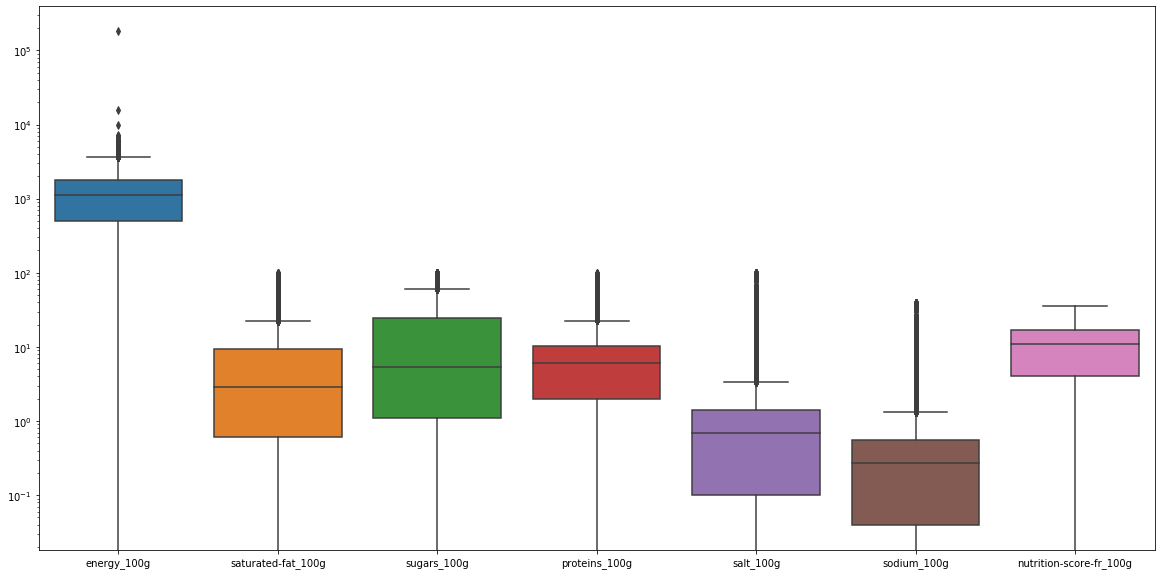

In [189]:
g=sns.boxplot(data=df[nutriment_cols])
g.set_yscale("log")


# Imputation des valeurs manquantes des variables quantitatives
  

In [190]:
## afin d'utiliser la méthode iterativeImputer, identification des variables suffisamment corrélées entre elles
numeric_columns=df.select_dtypes(exclude=['object']).columns.tolist()
corr_matrix = df[numeric_columns].corr().abs()



sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head()

salt_100g           sodium_100g                1.000000
saturated-fat_100g  nutrition-score-fr_100g    0.605212
energy_100g         nutrition-score-fr_100g    0.434128
sugars_100g         nutrition-score-fr_100g    0.424722
energy_100g         saturated-fat_100g         0.359098
dtype: float64

In [191]:
## les colonnes sel et sodium ont une corrélation positive absolue égale à 1, et sont confondues
## suppression de la variable sodium (sodium_100g)
df.drop(columns=['sodium_100g'],axis=1,inplace=True)
numeric_columns.remove('sodium_100g')
## les colonnes energy_100g,nutrition-score-fr_100g et saturated-fat_100g  corrélées positivement entre elles.
 # Utilisation Iterativeimputer pour imputer les valeurs manquantes
correlated_columns=['nutrition-score-fr_100g','saturated-fat_100g']
                    
un_correlated_columns=[x for x in numeric_columns if x not in correlated_columns]

un_correlated_columns

['additives_n',
 'ingredients_from_palm_oil_n',
 'energy_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g']

In [192]:
#imputation des valeurs nulles des variables corrélées entre elles par IterativeImputer

impute_it=IterativeImputer(missing_values=np.nan,min_value=0)
results=impute_it.fit_transform(df[correlated_columns])
df_imputed = pd.DataFrame(data = results,columns = correlated_columns)

In [193]:
#imputation des valeurs nulles des variables non corrélées entre elles par KNNimputer

        
        
imputer = KNNImputer()
results = imputer.fit_transform(df[un_correlated_columns])
df_imputed_2=pd.DataFrame(data = results,columns = un_correlated_columns)

In [194]:
df[correlated_columns]=df_imputed.values
df[un_correlated_columns]=df_imputed_2.values



In [195]:
## les variables quantitatives sont à 100% complètes
df[numeric_columns].isnull().sum()/len(df)*100

additives_n                    0.0
ingredients_from_palm_oil_n    0.0
energy_100g                    0.0
saturated-fat_100g             0.0
sugars_100g                    0.0
proteins_100g                  0.0
salt_100g                      0.0
nutrition-score-fr_100g        0.0
dtype: float64

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40431 entries, 106 to 320763
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_name                 40431 non-null  object 
 1   categories                   27630 non-null  object 
 2   additives_n                  40431 non-null  float64
 3   ingredients_from_palm_oil_n  40431 non-null  float64
 4   nutrition_grade_fr           37838 non-null  object 
 5   energy_100g                  40431 non-null  float64
 6   saturated-fat_100g           40431 non-null  float64
 7   sugars_100g                  40431 non-null  float64
 8   proteins_100g                40431 non-null  float64
 9   salt_100g                    40431 non-null  float64
 10  nutrition-score-fr_100g      40431 non-null  float64
dtypes: float64(8), object(3)
memory usage: 3.7+ MB


# Imputation des valeurs manquantes des variables qualitatives
  

In [197]:
qualitative_columns=df.select_dtypes(include=['object']).columns.tolist()


In [198]:
df[qualitative_columns].isnull().sum()/len(df)*100

product_name           0.000000
categories            31.661349
nutrition_grade_fr     6.413396
dtype: float64

In [199]:
 

df[qualitative_columns]=df[qualitative_columns].fillna("unknown") 


In [200]:
df.isnull().sum()/len(df)*100

product_name                   0.0
categories                     0.0
additives_n                    0.0
ingredients_from_palm_oil_n    0.0
nutrition_grade_fr             0.0
energy_100g                    0.0
saturated-fat_100g             0.0
sugars_100g                    0.0
proteins_100g                  0.0
salt_100g                      0.0
nutrition-score-fr_100g        0.0
dtype: float64

In [201]:
df.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,40431.000000,40431.000000,40431.000000,40431.000000,40431.000000,40431.000000,40431.000000,40431.000000
mean,1.737914,0.069397,1190.144092,6.348036,16.252571,7.783201,1.482604,11.020155
std,2.386084,0.248317,1198.174613,8.569365,20.371197,7.939194,4.946284,7.568611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,506.000000,0.700000,1.265000,2.000000,0.100000,4.000000
50%,1.000000,0.000000,1105.000000,3.200000,6.000000,6.000000,0.690000,11.018900
75%,2.400000,0.000000,1760.000000,8.900000,26.700000,10.200000,1.400000,16.000000
max,21.000000,2.000000,182764.000000,100.000000,100.000000,100.000000,100.000000,43.060569


In [207]:
## après imputation des valeurs manquantes, on remarque des valeurs aberrantes pour la variables energy
## nous allons identifier ses valeurs aberrantes
def find_outliers(col,df):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers= df[((df[col] < (Q1 - 1.5 * IQR)) |(df[col] > (Q3 + 1.5 * IQR))).any(axis=1)]
   
  
    if len(outliers)>0:
       
        return outliers['product_name'].values.tolist()
    else:
        #print('no outliers for column '+str(col[0])+' and category '+str(category))
        return []
outliers_energy=find_outliers(['energy_100g'],df)
outliers_energy_df=df[df['product_name'].isin(outliers_energy)][['product_name','categories','energy_100g']]
outliers_energy_df ##315 produits

,product_name,categories
56561,Tawny' Orange,unknown
68125,Beurre D'arachide (sans Sel Ni Sucre),unknown
115021,Huile d'Olive Vierge Extra Classico,"Aliments et boissons à base de végétaux,Alimen..."
115370,extra virgin cocos,Huiles de coco
177219,Frites & Fritures,"Matières grasses végétales,Huiles de Coprah"
...,...,...
315860,Huile de coco inodore - BioWise - 400 g,"Aliments et boissons à base de végétaux,Alimen..."
316993,virgin coconut oil,unknown
317235,Dee Thai Huile De Sésame,unknown
319695,Miel,unknown


In [211]:
## identification de tous les outliers de la variable energy dont la catégorie est inconnue
outliers_energy_df=outliers_energy_df[df['categories']=='unknown']
outliers_energy_df ## 136 outliers dont la catégorie est inconnue

/home/amadou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array(["Tawny' Orange", "Beurre D'arachide (sans Sel Ni Sucre)",
       'Confiserie Firenze Apfel Streuselkuchen Tiefgefror...',
       'Lot De 4 Baguettes',
       'Tomatentapenade Bakje 150 Gram (baresa) Koeling',
       'Sauce beurre blanc et citron confit', 'Diot de Savoie',
       'Huile de colza 1L', 'Rillettes De Poulet Roti',
       'Baguettines viennoises briochées', 'Confiture Bonne Maman 370g',
       'Olives Cocktail Pimentées, Le Sachet De',
       'Ecochard Quenelles Nature Barquette 4X120G',
       'Lesieur Huile Pepin Raisi',
       'Sirop Citron Bio au pur sucre de canne',
       'Sirop Saveur pina Colada', 'Chevre Pane',
       'Confiture Extra, 4 Fruits Rouges, 370 Grammes, Marque Casino',
       '1KG Nuggets Poulet Maitre Coq', 'Huile Vierge De Colza',
       'Huile De Pistache 250 ML - La Tourangelle',
       'La Tourangelle White Truffle Oil',
       '250ML Huile Avocat La Tourangelle', 'Huile pour ok thai',
       'Huile Infusee Au Basilic', "Huile Infusee A L'ai

In [212]:
## identification de tous les outliers de la variable energy dont la catégorie est inconnue
df.drop(df[df['product_name'].isin(outliers_energy_df['product_name'].values)].index, inplace = True)

In [213]:
df.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,40295.000000,40295.000000,40295.000000,40295.000000,40295.000000,40295.000000,40295.000000,40295.000000
mean,1.740404,0.069606,1175.170289,6.307490,16.270850,7.795226,1.485323,10.993131
std,2.389179,0.248700,766.196829,8.407967,20.364816,7.937021,4.952596,7.561548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,504.000000,0.700000,1.300000,2.100000,0.100000,4.000000
50%,1.000000,0.000000,1100.000000,3.200000,6.100000,6.000000,0.690000,11.018900
75%,2.400000,0.000000,1751.000000,8.800000,26.790000,10.300000,1.400000,16.000000
max,21.000000,2.000000,15481.000000,100.000000,100.000000,100.000000,100.000000,43.060569


In [214]:
df.to_csv('./cleaned_food.csv',index=False)